In [1]:
import zetta_utils
from zetta_utils.geometry.bbox import BBox3D
from zetta_utils.geometry.vec import Vec3D
from zetta_utils.layer.volumetric.cloudvol.build import build_cv_layer
import numpy as np
import fastremap
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import ipywidgets as widgets
%matplotlib widget

/home/joe/miniconda3/envs/full/lib/python3.11/site-packages/python_jsonschema_objects/__init__.py:113: UserWarning: Schema id not specified. Defaulting to 'self'
  warnings.warn("Schema id not specified. Defaulting to 'self'")


In [2]:
data_res = Vec3D(4, 4, 13)
index_res = Vec3D(4, 4, 13)
cv_path = "gs://zetta-eon-x1/ingest/241015_RT-50micron_220_SingleStack_stretched"
cv_layer = build_cv_layer(cv_path, default_desired_resolution=data_res, allow_slice_rounding=True)


Using default Google credentials. There is no ~/.cloudvolume/secrets/google-secret.json set.

        google-cloud-python might not find your credentials. Your credentials
        might be located in $HOME/.config/gcloud/legacy_credentials/$YOUR_GMAIL/adc.json

        If they are you can export your credentials like so:
        export GOOGLE_APPLICATION_CREDENTIALS="$HOME/.config/gcloud/legacy_credentials/$YOUR_GMAIL/adc.json"
      


In [3]:
start_coord = Vec3D(0, 0, 100)

end_coord = Vec3D(512, 512, 200) # Vec3D(2048, 2048, 500)

data_bbox = BBox3D.from_coords(start_coord, end_coord, resolution=index_res)
data_raw = cv_layer[data_bbox][0]  # select channel 0

In [4]:
data_raw.shape

(512, 512, 100)

In [5]:
# visualize one Z-slice
# z = 200
# z_slice = data_raw[:, :, z]

# # Plot the Z-slice
# plt.figure(figsize=(8, 8))
# plt.imshow(z_slice) #, cmap=cmap)
# #plt.colorbar()
# plt.title('Z-slice visualization')
# plt.show()

Output()

IntSlider(value=0, description='Z-slice:', max=99)

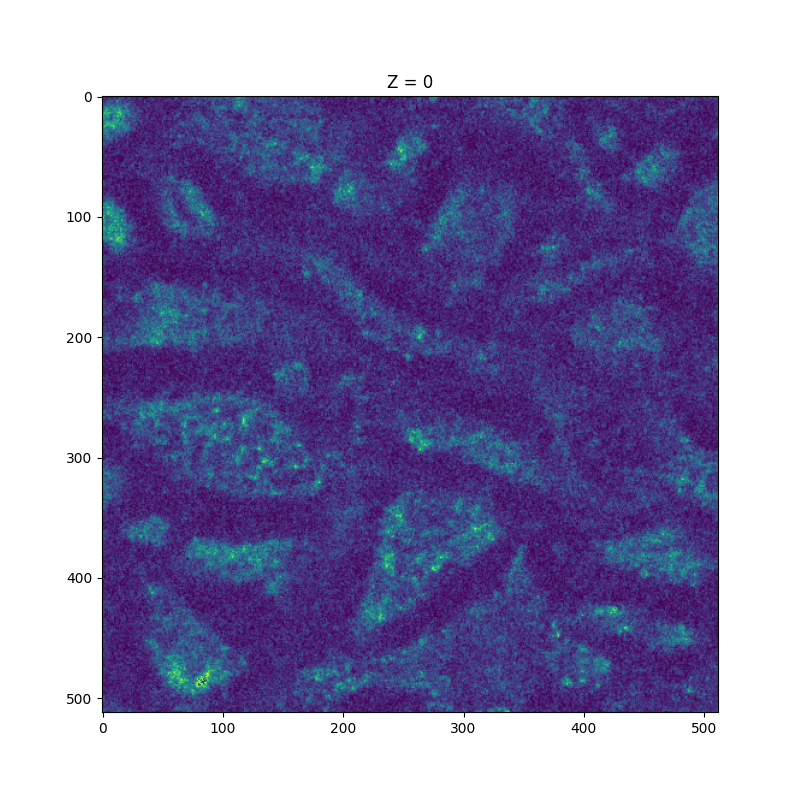

In [15]:
# Let's get fancier: a plot with a slider that lets you scrub through Z!
from IPython.display import display, clear_output

# Create the initial figure and axis outside the update function
fig, ax = plt.subplots(figsize=(8, 8))
img = None  # Will store our image object

def update_plot(z_index):
    global img
    z_slice = data_raw[:, :, z_index]
    
    if img is None:
        # First time: create the image
        img = ax.imshow(z_slice)
    else:
        # Subsequently: just update the data
        img.set_array(z_slice)
    
    ax.set_title(f'Z = {z_index}')
    fig.canvas.draw_idle()  # Redraw the figure

# Create an interactive slider
z_slider = widgets.IntSlider(min=0,  max=data_raw.shape[2] - 1, description='Z-slice:')

# Create the interactive output
output = widgets.interactive_output(update_plot, {'z_index': z_slider})

# Display the slider and the plot output
display(output, z_slider)


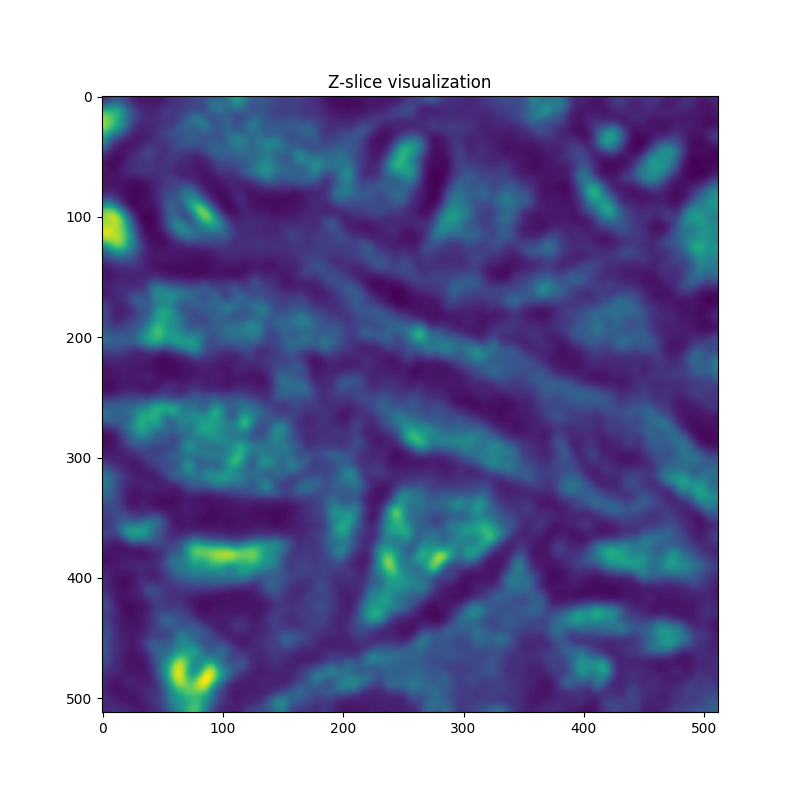

In [16]:
# The data are very noisy.  Let's smooth it a bit with a Gaussian blur.
from scipy import ndimage
data_smooth = ndimage.gaussian_filter(data_raw.astype(float), sigma=4.0).astype(np.uint8)
z_slice = data_smooth[:, :, 0]

# Plot the Z-slice
plt.figure(figsize=(8, 8))
plt.imshow(z_slice) #, cmap=cmap)
plt.title('Z-slice visualization')
plt.show()

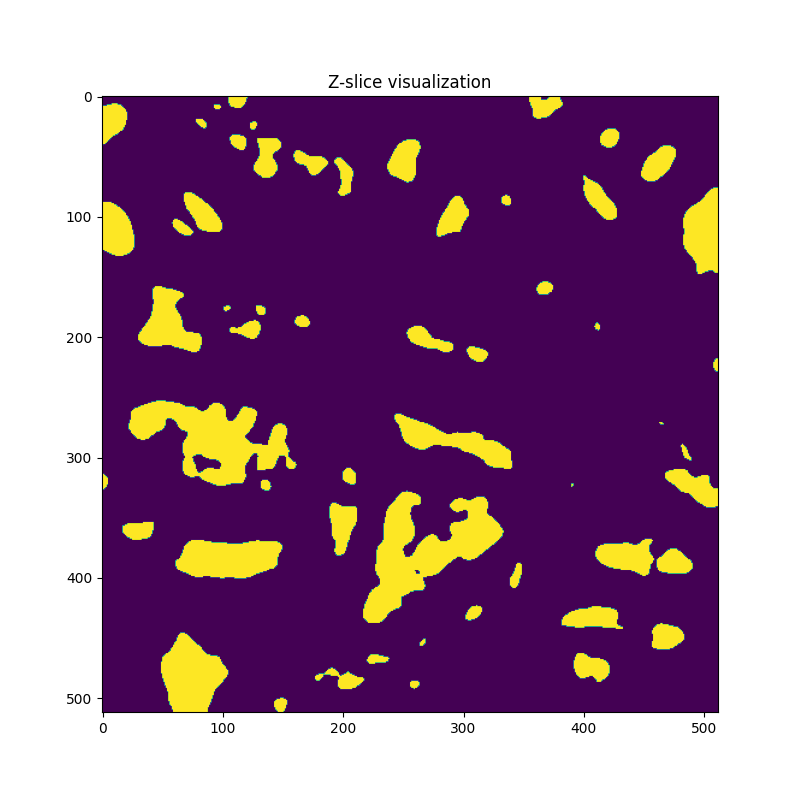

In [13]:
# Threshold
threshold = 60
thresholded_slice = (z_slice > threshold).astype(int)

plt.figure(figsize=(8, 8))
plt.imshow(thresholded_slice) #, cmap=cmap)
plt.title('Z-slice visualization')
plt.show()

Found 80 segments


Output()

IntSlider(value=0, description='Z-slice:', max=14)

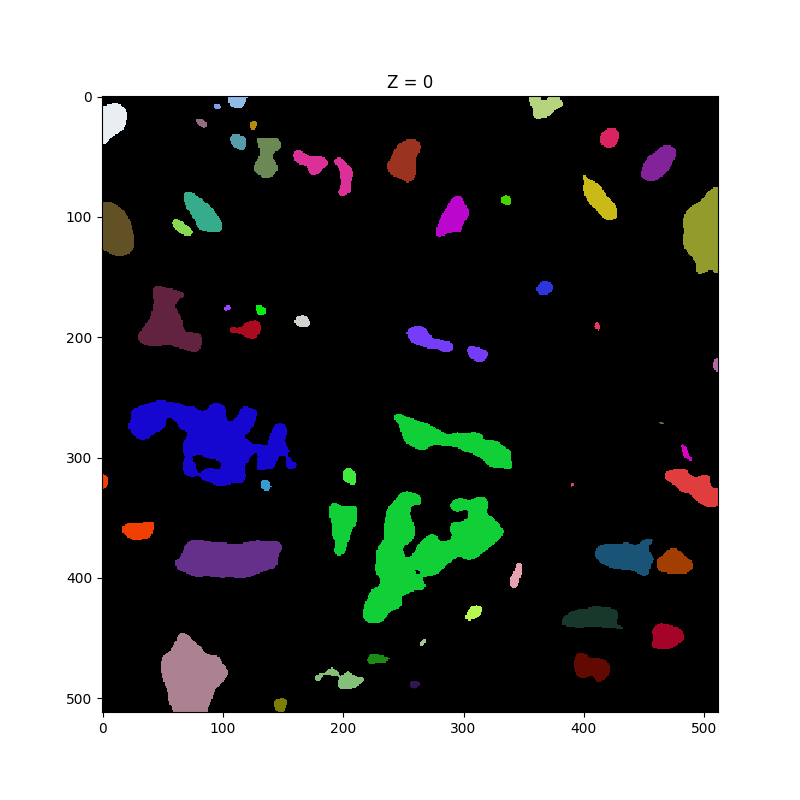

In [14]:
from scipy import ndimage

mask = data_smooth[:,:,0:15] > threshold
segments, qty_segments = ndimage.label(mask)
print(f'Found {qty_segments} segments')

random_rgb = [[0,0,0]] + np.random.rand(qty_segments, 3)  # Generate random RGB colors
random_rgb[0] = [0,0,0]  # ...but ensure color 0 is black
random_cmap = mcolors.ListedColormap(random_rgb)

# Create the initial figure and axis outside the update function
fig, ax = plt.subplots(figsize=(8, 8))
img = None  # Will store our image object

def update_plot(z_index):
    global img
    z_slice = segments[:, :, z_index]
    
    if img is None:
        # First time: create the image
        img = ax.imshow(z_slice, cmap=random_cmap, interpolation='nearest')
    else:
        # Subsequently: just update the data
        img.set_array(z_slice)
    
    ax.set_title(f'Z = {z_index}')
    fig.canvas.draw_idle()  # Redraw the figure

# Create an interactive slider
z_slider = widgets.IntSlider(
    min=0, 
    max=segments.shape[2] - 1, 
    step=1, 
    value=0, 
    description='Z-slice:'
)

# Create the interactive output
output = widgets.interactive_output(update_plot, {'z_index': z_slider})

# Display the slider and the plot output
display(output, z_slider)